# Global Sensitivity Analysis
 **Saleh Rezaeiravesh and Philipp Schlatter** <br/> 
 saleh.rezaeiravesh@manchester.ac.uk and pschlatt@mech.kth.se <br/> 
 Modelling & Simulation, Department of Mechanical, Aerospace and Civil Engineering (MACE), The University of Manchester, UK <br/> 
 SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Sweden
___

In [1]:
import sys
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.integrate import simps
sys.path.append('./modules')
import grafix

### Learning Objectives
* Getting familiar with GSA, ANOVA, Sobol decomposition and indices,
* Understanding the differences between GSA and LSA,
* Applying GSA to different problems.

## Motivational Example
The following example is adopted from [Saltelli et al. 2007](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184). 
Consider a linear model $y=f(\mathbf{q})=c_1 q_1+c_2 q_2$ where $q_1\sim\mathcal{N}(0,\sigma^2_1)$ and $q_2\sim\mathcal{N}(0,\sigma^2_2)$. Also assume $c_1=3$ and $c_2=1$.
The main idea is to study the sensitivity of response $y$ to $q_1$ and $q_2$. 

Using the local sensitivity analysis (LSA), we get the following sensitivity indices:

$$
\begin{equation}
s_1=\frac{\partial f}{\partial q_1} = 3 \,,\quad
s_2=\frac{\partial f}{\partial q_2} = 1 \,,
\end{equation}
$$

which imply fixed sensitivities independent of the distribution and variation of the parameters. 
Moreover, parameter $q_1$ shows a higher impact on $y$ than $q_2$. 

But, let us draw samples from the parameters and show how $y$ varies with the parameters when their distribution is taken into account. 

(1000, 2)


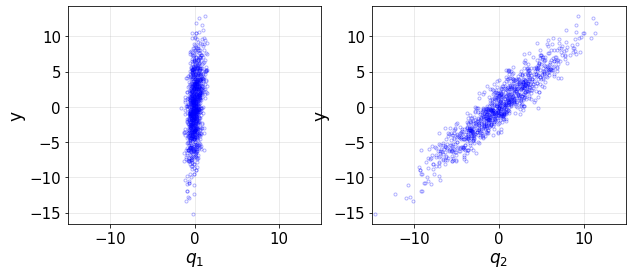

In [2]:
sig1=0.5  #standard deviation of q1
sig2=4    #standard deviation of q2
c1=3
c2=1

#draw joint samples for the parameters 
K=np.asarray([[sig1**2,0],[0,sig2**2]])
q = np.random.multivariate_normal(mean=[0,0], cov=K, size=1000)

print(q.shape)
#model function
y=c1*q[:,0]+c2*q[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(q[:,0],y,'ob',mfc='none',ms=3,alpha=0.3)
plt.xlabel(r'$q_1$');plt.ylabel('y')
plt.xlim([-15,15])
plt.grid(alpha=0.3)
plt.subplot(122)
plt.plot(q[:,1],y,'ob',mfc='none',ms=3,alpha=0.3)
plt.xlabel(r'$q_2$');plt.ylabel('y')
plt.xlim([-15,15])
plt.grid(alpha=0.3)

Clearly, variation of $q_2$ has more influence on $y$ than that of $q_1$, which is an observation opposite to what we could be inferred from the LSA. 

Therefore, we need to account for the contribution of each parameters in the resulting variance of $y$:

$$
\begin{equation}
S_i = \frac{\sigma_i}{\sigma_y}s_i \,, \text{for}\, i=1,2 \,,
\end{equation}
$$

where for the present problem $\sigma_y^2= c_1^2 \sigma_1^2+c_2^2\sigma_2^2$. For the above settings, it is resulted that:

In [3]:
sigY=mt.sqrt(c1**2*sig1**2+c2*sig2**2)
S1=c1*sig1/sigY
S2=c2*sig2/sigY
print('S1=%g , S2=%g' %(S1,S2))

S1=0.351123 , S2=0.936329


## Global Sensitivity Analysis (GSA)
GSA aims at quantifying the influence of parameters and their interactions on the response while all parameters are allowed to vary according to their distributions. 

Compared to LSA, GSA has several advantages:
* GSA is an efficient way to rank the influence of the parameters on the response.
* All parameters are allowed to vary at the same time.
* No linearization of the model response is needed. 
* All interactions between parameters can be taken into account.
* GSA fits well with the sample-based uncertainty propagation problems. 

But, doing GSA is more involved and hence potentially requires more computational effort compared to LSA. There are different ways for doing GSA, but here we only look at the Sobol indices [Sobol 2001](http://www.andreasaltelli.eu/file/repository/Sobol_2001.pdf) (Note that these indices are older, Sobol 1969 (in Russian)). 

Consider the model function 

$$
\begin{equation}
y=f(\mathbf{q})
\end{equation}
$$

with $\mathbf{q}\in \mathbb{Q}\subset \mathbb{R}^p$. The parameters have joint distribution $\rho(\mathbf{q})$. In this notebook, we assume the parameters to be  mutually independent. Therefore the formulations and examples are constrained on this. 

### ANOVA
ANalysis Of VAriance (ANOVA) is one of the main appraoches for computing GSA using Sobol indices.



$$
\begin{equation}
D_i=\mathbb{V}[\mathbb{E}(y|q_i)]
\end{equation}
$$

Total variance of the response due to the variation of all parameters $\mathbf{q}$:
$$
\begin{equation}
D=\mathbb{V}[y]
\end{equation}
$$

Main Sobol index for the $i$-th parameter is defined as:

$$
\begin{equation}
S_i=\frac{D_i}{D}
\end{equation}
$$

Variance in the respones due to the simultaneous variation of $q_i$ and $q_j$:

$$
\begin{equation}
D_{ij}=\mathbb{V}[\mathbb{E}[Y|q_i,q_j]] - D_i - D_j
\end{equation}
$$

Which results in the dual-interaction Sobol index:

$$
\begin{equation}
S_{ij}=\frac{D_{ij}}{D}
\end{equation}
$$

The following implementations are simplified versions of the codes for general cases provided by [UQit](https://github.com/KTH-Nek5000/UQit). The simplifications here are for educational purposes, and the resulting script works only for two parameters. 

Sobol decomposition:

In [4]:
def sobolDecomp_dualInteraction(Q,f,pdf):
    """    
    Compute coefficients f0, f1(q1), f2(q2), f12(q1,q2) in the 2nd-order Sobol decomposition (HDMR)
    Args:
       `q`: [Q1|Q2] a list of two 1d numpy array Qi of size ni
       `f`: 2d numpy array of size(n1,n2)
    """
    p=2
    n=[]
    for i in range(p):
        n.append(len(Q[i]))

    #Compute f1(q1), f2(q2) and q0
    fi=[]
    for i in range(p):
        I=p-i-1   
        if i==0:
           f_=f*pdf[I]
        elif i==1:
           f_=(f.T*pdf[I]).T
        fi.append(simps(f_,Q[I],axis=-I))   #fi(qi)+q0
        
    f0=simps(fi[0]*pdf[0],Q[0])          #q0=E(f(q1,q2))
    fi[:]=fi[:]-f0   #fi(qi)
    fij=np.zeros((n[0],n[1]))   #f12(q1,q2): interaction term
    for i2 in range(n[1]):
        for i1 in range(n[0]):
            fij[i1,i2]=f[i1,i2]-fi[0][i1]-fi[1][i2]-f0
    return f0,fi,fij

Evaluation of the Sobol indices

In [5]:
def SobolIndices(Q,f,pdf):
    """
       Compute Sobol sensitivity indices for f(Q1,Q2)
       Q=[Q1|Q2|...|Qp], list of p 1d numpy array
       Qi:numpy 1d array of size ni, i=1,2,...,p
       f: numpy p-d array: f(n1,n2,...,np)
    """
    p=len(Q)
    if p==2:
       #Sobol (HDMR) decomposition
       f0,fi,f12=sobolDecomp_dualInteraction(Q,f,pdf)
       #1st-order variances
       Si=[]
       for i in range(p):
           Si.append(simps(fi[i]**2.*pdf[i],Q[i]))
       #2nd-order variance
       Sij=[]       
       pdf_=pdf[0][:,None]*pdf[1]
       f12_=np.multiply(f12**2.,pdf_)              
       Sij.append(doubleInteg(f12_,Q[0],Q[1]))
    else:
       raise ValueError('p>2 is not implemented!')

    #Sum of variances
    D=sum(Si)+sum(Sij)
    #Main Sobol indices
    Si=Si/D
    Sij=Sij/D
    return Si,Sij

In [6]:
def doubleInteg(g,x1,x2):
    """
       Numerical double integral \int_{x2} \int_{x1} g(x1,x2) dx1 dx2
       g: 2d numpy array of size (n1,n2)
       x1,x2: 1d numpy arrays of sizes n1 and n2, resp.       
    """
    T_=simps(g,x2,axis=1)
    T=simps(T_,x1)
    return T

## Example: Linear Model


Here, we compute the Sobol indices for the motivational example where

$$
f(\mathbf{q})=c_1 q_1 + c_2 q_2 \,,
$$
where $q_i\sim\mathcal{N}(0,\sigma_i^2)$ for $i=1,2$.

Note that, we can analytically dervie expressions for the Sobol indices of these function. But here, we only compute the indices. 

In [7]:
n=[101, 100]        #number of samples for q1 and q2
qBound=[[-20,20],   #admissible range of parameters
        [-20,20]]
sig=[1.,3.]         #sdev of q1 and q2
c=[2,1]             #constants

Create samples for the parameters and evaluate the PDFs at the samples.

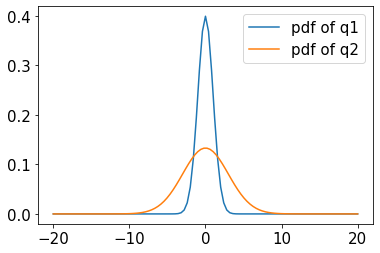

In [8]:
q=[]
pdf=[]
for i in range(2):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
    pdf_=np.exp(-q[i]**2/(2*sig[i]**2))/(sig[i]*mt.sqrt(2*mt.pi))
    pdf.append(pdf_)
    plt.plot(q[i],pdf[i],label='pdf of q'+str(i+1))
plt.legend(loc='best')
plt.show()

In [9]:
fEx=np.zeros(n)
for j in range(n[1]):
    for i in range(n[0]):
        fEx[i,j]=c[0]*q[0][i]+c[1]*q[1][j]
print(fEx.shape)        

(101, 100)


In [10]:
Si,Sij=SobolIndices(q,fEx,pdf)
print('S1=%g  , S2=%g' %(Si[0],Si[1]))
print('S12=%g' %(Sij[0]))

S1=0.307692  , S2=0.692308
S12=1.93492e-22


/home/saleh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Example: Rosenbrock Function




In [11]:
Rsbrk = lambda a,b,q1, q2 : a*(q2-q1**2)**2+(b-q1)**2

def rosenbrock_Sobol():
    """
       Compute Sobol indices of Rosenbrock using myUQtoolbox, 
       Note that they can be also analytically computed.
    """
    #--------------------------
    #------- SETTINGS 
    n=[500, 501]       #number of samples for q1 and q2
    qBound=[[-0.5,0.5],   #admissible range of parameters
            [1.0,2]]
    #--------------------------
    #(1) Samples from parameters space
    q=[]
    pdf=[]
    for i in range(2):
        q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
        pdf.append(np.ones(n[i])/(qBound[i][1]-qBound[i][0]))        
    
    #make a grid from the test points
    fGrid=np.zeros((n[0],n[1]))
    #evaluate the reponse at test points
    for i2 in range(n[1]):
        for i1 in range(n[0]):
            q1_=q[0][i1]
            q2_=q[1][i2]
            fGrid[i1,i2]=Rsbrk(100,1,q1_,q2_)
    print(fGrid.shape)            
    #(3) Compute Sobol indices direct numerical integration
    Si,Sij=SobolIndices(q,fGrid,pdf)
    return Si,Sij

In [12]:
Si,Sij=rosenbrock_Sobol()
print('S1=%g  , S2=%g' %(Si[0],Si[1]))
print('S12=%g' %(Sij[0]))

(500, 501)
S1=0.059589  , S2=0.937836
S12=0.00257471


/home/saleh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Hands-on: Projectile Motion
Consider a projectile of mass $m$ that is projected with initial velocity $v_0$ and angle $\alpha$ (measured from horizontal plane) into the Earth's gravitational field ($g=9.81 \, m^2/s$).
We can show that the projectile's horizontal and vertical locations $x$ and $y$, respectively, over time $t$ are given by (see e.g. [here](https://en.wikipedia.org/wiki/Projectile_motion)):

$$
x=v_0\cos(\alpha)t,
y=v_0\sin(\alpha)t - gt^2/2 \,,
$$
where the initial location is assumed to be at the $x=0$ and $y=0$. 
Removing $t$ between these two expressions leads to the following expression for the projectile's path:

$$
\begin{equation}
y=\tan(\alpha) x - \frac{g}{2v_0^2\cos^2(\alpha)}x^2 = f(x,\mathbf{q}) \,,
\end{equation}
$$

where $\mathbf{q}=[\alpha,v_0]$ and $g=9.81$ is fixed.

Assume $\alpha\sim \mathcal{N}(1,0.2^2)$ and $v_0\sim\mathcal{U}[0.8,1]$. For these random parameters, compute the Sobol indices for the response $y$ at a few $x$, say $x=[1,10,50]$.

In [13]:
def yProjectile(x,alpha,v0):
    """
    Projectile's vertical position 
    """
    g=9.81
    y=x*mt.tan(alpha)-g*x**2/(2*v0**2*mt.cos(alpha)**2)
    return y

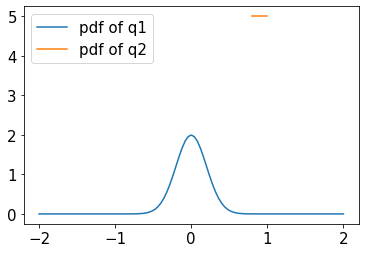

In [14]:
# settings
n=[101, 100]        #number of samples for q1 and q2
xList=[1,10,50]
qInfo=[[1,0.2],[0.8,1]]

#create data
qBound=[[qInfo[0][0]-15*qInfo[0][1],qInfo[0][0]+5*qInfo[0][1]],qInfo[1]]
q=[]
pdf=[]
for i in range(2):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
pdf1=np.exp(-q[0]**2/(2*qInfo[0][1]**2))/(qInfo[0][1]*mt.sqrt(2*mt.pi))
pdf2=np.ones(n[1])/(qBound[1][1]-qBound[1][0])        


#plot PDF
pdf=[pdf1,pdf2]
for i in range(2):
    plt.plot(q[i],pdf[i],label='pdf of q'+str(i+1))
plt.legend(loc='best')
plt.show()

In [15]:
#compute Sobol indices 
yProj=np.zeros(n)
for x in xList:
    for j in range(n[1]):
        for i in range(n[0]):
            yProj[i,j]=yProjectile(x,q[0][i],q[1][j])
    Si,Sij=SobolIndices(q,yProj,pdf)
    print('Indices at x = ',x)
    print('   S1=%g  , S2=%g' %(Si[0],Si[1]))
    print('   S12=%g' %(Sij[0]))    


Indices at x =  1
   S1=0.240932  , S2=0.755858
   S12=0.00321014
Indices at x =  10
   S1=0.202793  , S2=0.793836
   S12=0.00337143
Indices at x =  50
   S1=0.202404  , S2=0.794223
   S12=0.00337308


/home/saleh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
